<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/Michael/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
from tqdm import tqdm

# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, fbeta_score, jaccard_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

# Plot ROC AUC Curve & Visualisation
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, PrecisionRecallCurve

import matplotlib.pyplot as plt
%matplotlib inline



# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Configuration**

In [2]:
%%time

RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])
cleaned_df = pd.read_csv('Datasets/cleaned_df.csv', lineterminator = '\n') # reading the datasest

# Data pre-processing using conventional method (ok accuracy / fast speed)
def clean_text(comments):
  punc = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
  punc_removed = [char for char in comments if char not in punc]
  punc_join = ''.join(punc_removed)
  cleaned = []
  splitted = punc_join.split()
  for x in splitted:
    if x.isalpha() and x not in stop_words:
      cleaned.append(x.lower())
  result = ' '.join(cleaned)
  return result

cleaned_df['cleaned_comments'] = cleaned_df['comments'].apply(clean_text)

# TfidfVectorizer:
min_df = 25

# Logistic Regression:
solver = 'lbfgs'
multi_class = 'auto'

# RF & Adaboost:
n_estimators = 10
max_depth = 3

# K Nearest Neighbour:
k = 3

CPU times: user 1min 5s, sys: 2.6 s, total: 1min 7s
Wall time: 1min 21s


**Downsampling method for imbalance dataset**

In [3]:
cleaned_df['sentiment'].value_counts()

Positive    1045528
Neutral       25786
Negative      16185
Name: sentiment, dtype: int64

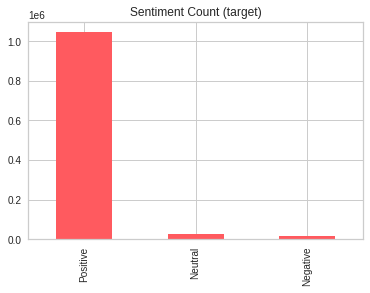

In [4]:
cleaned_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title = 'Sentiment Count (target)')

class_positive: (1045528, 14)
class_neutral: (25786, 14)
class_negative: (16185, 14)
Random Under Sampling leads to.........


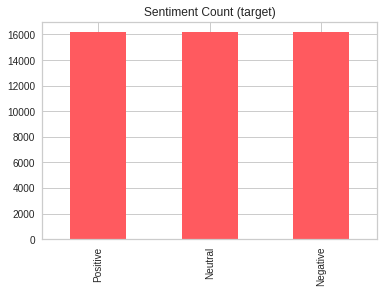

In [5]:
# class count
class_count_positive, class_count_neutral, class_count_negative = cleaned_df['sentiment'].value_counts()


# Separate sentiment into each df
class_positive = cleaned_df[cleaned_df['sentiment'] == "Positive"]
class_neutral = cleaned_df[cleaned_df['sentiment'] == "Neutral"]
class_negative = cleaned_df[cleaned_df['sentiment'] == "Negative"]

print('class_positive:', class_positive.shape)
print('class_neutral:', class_neutral.shape)
print('class_negative:', class_negative.shape)
print("Random Under Sampling leads to.........")
      
# As negative sentiment is the lowest case count, we will do random undersampling for both positive and neutral sentiments to get an equally distributed and balanced dataset
class_positive_under = class_positive.sample(class_count_negative, random_state = RANDOM_SEED)
class_neutral_under = class_neutral.sample(class_count_negative, random_state = RANDOM_SEED)

# Combine all dataframes
cleaned_df_undersampling = pd.concat([class_positive_under, class_neutral_under, class_negative], axis = 0)
cleaned_df_undersampling['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title ='Sentiment Count (target)')

In [6]:
#cleaned_df_undersampling.to_csv('cleaned_df_undersampling.csv')

**Split datasets into train, validation and test sets**

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively.

In [7]:
def get_train_val_test(df, fractions, RANDOM_SEED):

  # Get the required input and target variables from dataframe and drop NA rows:
  df = df[['cleaned_comments','sentiment']].dropna()
  # shuffling the data:
  df = df.sample(frac = 1, random_state = RANDOM_SEED)
  # split into training, validation and testing sets
  train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

  if len(train_df) + len(val_df) + len(test_df) != len(df):
    print("Check the splitting method!")
  else:
    return train_df, val_df, test_df

**Splitting...**

In [8]:
train_df, val_df, test_df = get_train_val_test(cleaned_df_undersampling, fractions, RANDOM_SEED)

**Convert text data to features - TF-IDF and get target input**

In [9]:
%%time
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = min_df, norm ='l2')
X_train = vectorizer.fit_transform(train_df.cleaned_comments)
y_train = list(train_df.sentiment)

CPU times: user 1.15 s, sys: 39 ms, total: 1.19 s
Wall time: 1.22 s


**Fit the classifier on the data**

In [10]:
%%time
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_log.fit(X_train, y_train)

CPU times: user 3.04 s, sys: 54 ms, total: 3.1 s
Wall time: 3.56 s


LogisticRegression(random_state=42)

**Generate validation data**

In [11]:
%%time
X_val = vectorizer.transform(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

CPU times: user 236 ms, sys: 13.7 ms, total: 249 ms
Wall time: 386 ms


**Generate logistic regression (baseline model) prediction**

Logistic regression is a good model because it trains quickly even on large datasets and provides very robust results. Other good model choices include SVMs, Random Forests, and Naive Bayes.

In [12]:
%%time
lr_pred = clf_log.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred, average = 'macro')
print("F1 score for baseline regression:", lr_f1)

F1 score for baseline regression: 0.9173549143464004
CPU times: user 30.2 ms, sys: 6.87 ms, total: 37.1 ms
Wall time: 42.5 ms


**Comparing all classification models**

In [13]:
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_svm = svm.SVC(decision_function_shape = 'ovr', probability = True, random_state = RANDOM_SEED)
clf_svm_ = svm.SVC(decision_function_shape = 'ovr', random_state = RANDOM_SEED) # without probability = True
clf_nb = MultinomialNB()
clf_dt = tree.DecisionTreeClassifier(random_state = RANDOM_SEED)
clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
clf_gbc = GradientBoostingClassifier(random_state = RANDOM_SEED)
clf_boost = AdaBoostClassifier(random_state = RANDOM_SEED)
clf_xtratree = ExtraTreesClassifier(random_state = RANDOM_SEED)
clf_knn = KNeighborsClassifier(n_neighbors = k)

model_names = ["LogisticRegression (Base)", "SupportVectorMachine", "MultinomialNB", "DecisionTreeClassifier", 
               "RandomForestClassifier", "GradientBoostingClassifier", "AdaBoostClassifier", "ExtraTreesClassifier", "KNeighborsClassifier"]

model_list = [clf_log, clf_svm, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]
model_list_ = [clf_log, clf_svm_, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]

In [21]:
accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in tqdm(model_list):
  model.fit(X_train, y_train)
  model_predict = model.predict(X_val)
  accuracy.append(accuracy_score(model_predict, y_val))
  precision.append(precision_score(model_predict, y_val, average = 'macro'))
  recall.append(recall_score(model_predict, y_val, average = 'macro'))
  f1score.append(f1_score(model_predict, y_val, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_val, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_val, model.predict_proba(X_val)))

100%|██████████| 9/9 [36:31<00:00, 243.47s/it]


In [64]:
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision (Macro),Recall (Macro),F1 Score (Macro),Jaccard Score (Macro),F-beta Score (Macro),AUC ROC Score,Log Loss
0,LogisticRegression (Base),0.917405,0.917423,0.917317,0.917355,0.848002,0.917392,0.978716,0.275187
1,SupportVectorMachine,0.918023,0.918027,0.918937,0.918316,0.849698,0.918102,0.978504,0.264870
2,MultinomialNB,0.805973,0.804541,0.837003,0.800854,0.669427,0.799297,0.965882,0.464833
3,DecisionTreeClassifier,0.844902,0.845106,0.844760,0.844843,0.735042,0.844980,0.872303,5.192471
4,RandomForestClassifier,0.897425,0.897350,0.898024,0.897460,0.815336,0.897339,0.971416,0.356477
5,GradientBoostingClassifier,0.877240,0.877357,0.876875,0.876360,0.781339,0.876778,0.965765,0.409064
6,AdaBoostClassifier,0.845726,0.845793,0.847777,0.842631,0.731398,0.843556,0.861810,1.019145
7,ExtraTreesClassifier,0.904840,0.904783,0.905709,0.905083,0.827693,0.904864,0.972824,0.379646
8,KNeighborsClassifier,0.413182,0.416243,0.624552,0.327113,0.208028,0.351120,0.580612,18.465690


**ROC-AUC Curve plots**

In [23]:
def plot_ROC_curve(model, X_train, y_train, X_val, y_val):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder = {'Positive': 'Positive', 
                                          'Neutral': 'Neutral', 
                                          'Negative': 'Negative'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

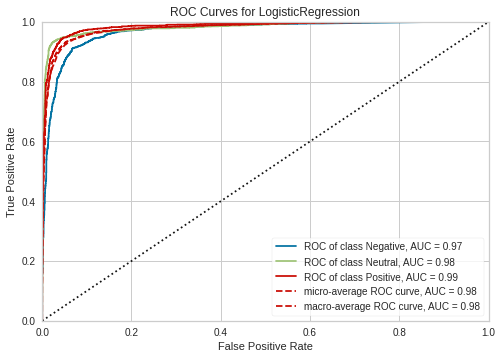

 11%|█         | 1/9 [00:00<00:02,  3.74it/s]

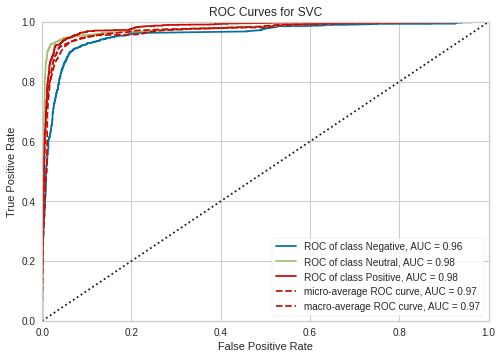

 22%|██▏       | 2/9 [06:58<28:41, 245.98s/it]

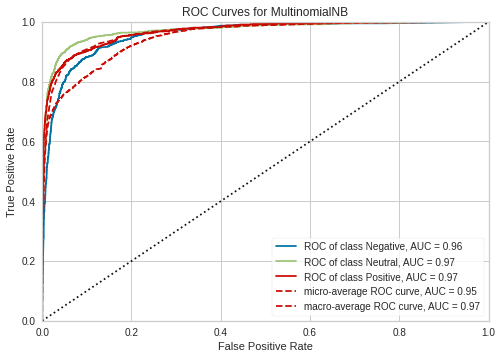

 33%|███▎      | 3/9 [06:58<13:22, 133.79s/it]

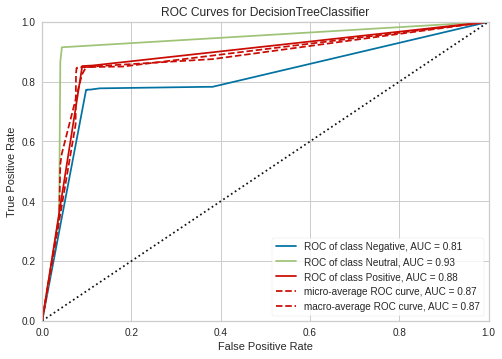

 44%|████▍     | 4/9 [06:58<06:45, 81.10s/it] 

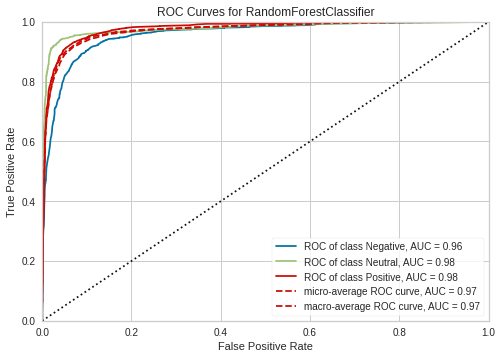

 56%|█████▌    | 5/9 [06:59<03:28, 52.16s/it]

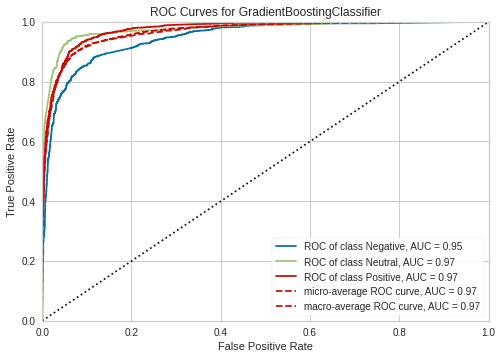

 67%|██████▋   | 6/9 [07:00<01:43, 34.54s/it]

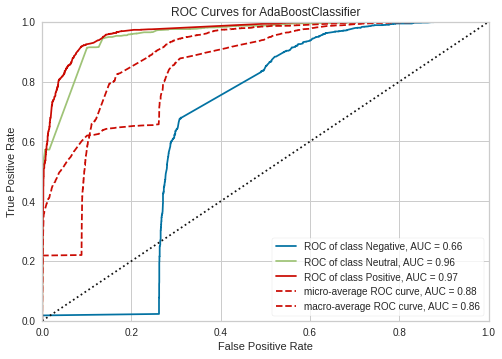

 78%|███████▊  | 7/9 [07:00<00:46, 23.39s/it]

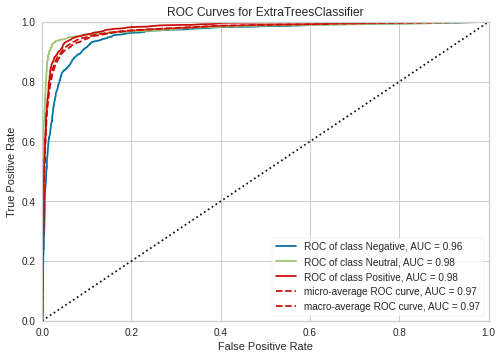

 89%|████████▉ | 8/9 [07:01<00:16, 16.30s/it]

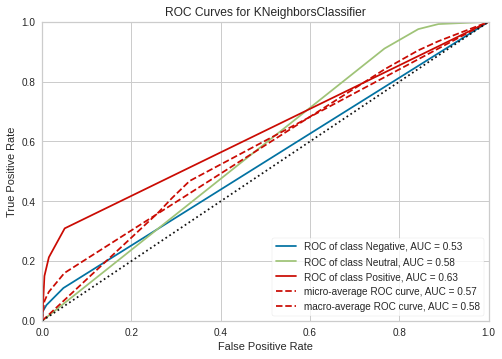

In [24]:
for model in tqdm(model_list_):
  plot_ROC_curve(model, X_train, y_train, X_val, y_val)

In [71]:
def plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val):

    classes = ['Positive', 'Neutral', 'Negative']
    visualizer = ConfusionMatrix(
        model, classes = classes,
        percent = True,
        label_encoder = {'Positive': 'Positive', 
                         'Neutral': 'Neutral', 
                         'Negative': 'Negative'},
        fig = plt.figure(figsize=(8,8)))

    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

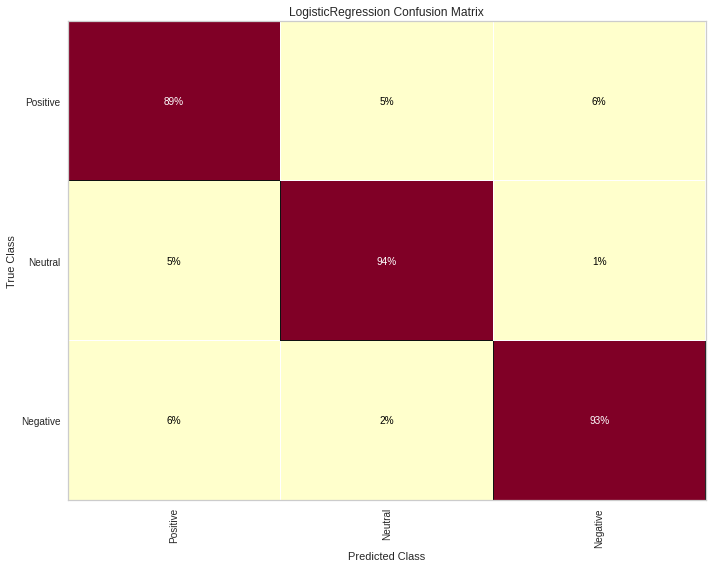

 11%|█         | 1/9 [00:00<00:01,  4.39it/s]

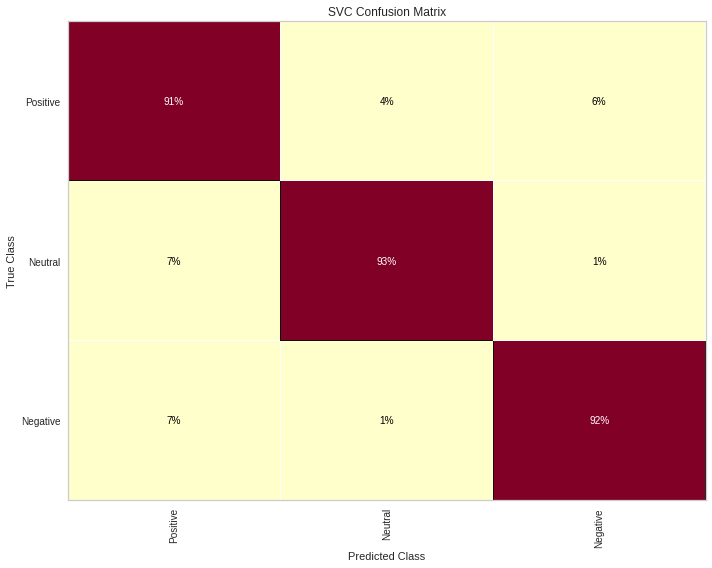

 22%|██▏       | 2/9 [00:38<02:37, 22.48s/it]

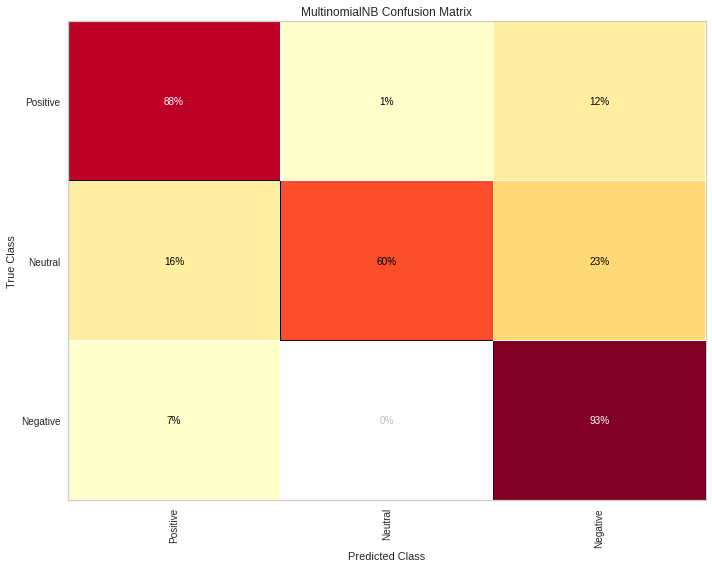

 33%|███▎      | 3/9 [00:38<01:13, 12.32s/it]

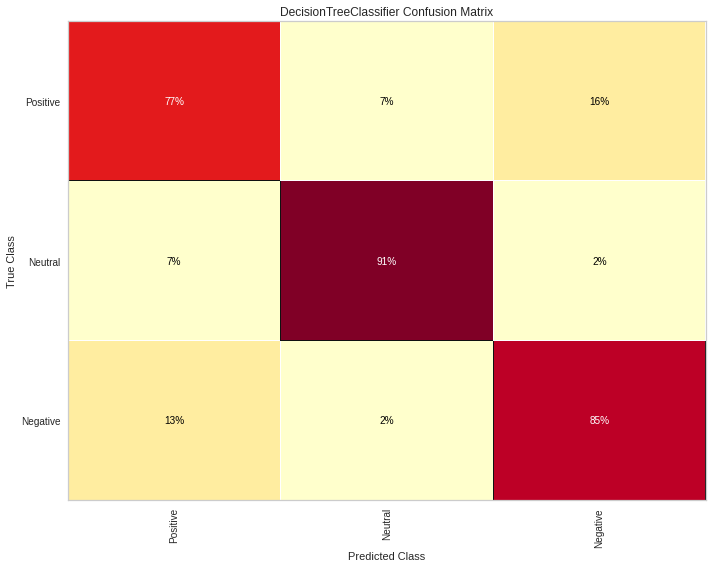

 44%|████▍     | 4/9 [00:38<00:37,  7.55s/it]

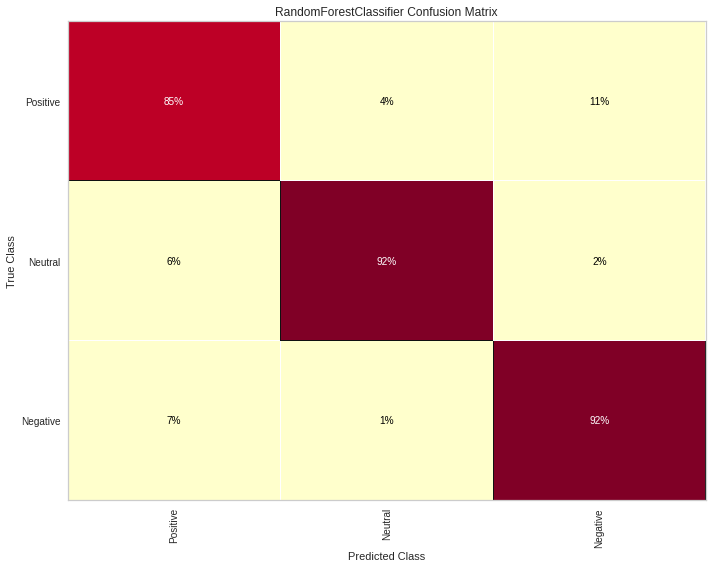

 56%|█████▌    | 5/9 [00:39<00:20,  5.10s/it]

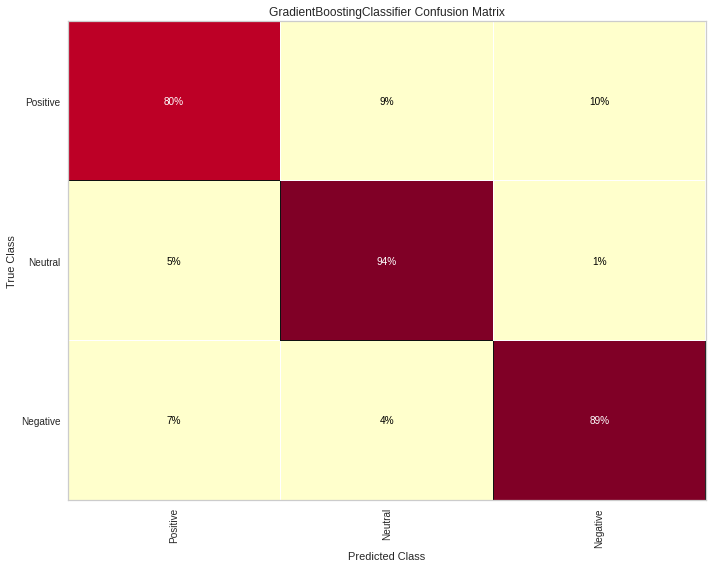

 67%|██████▋   | 6/9 [00:39<00:10,  3.47s/it]

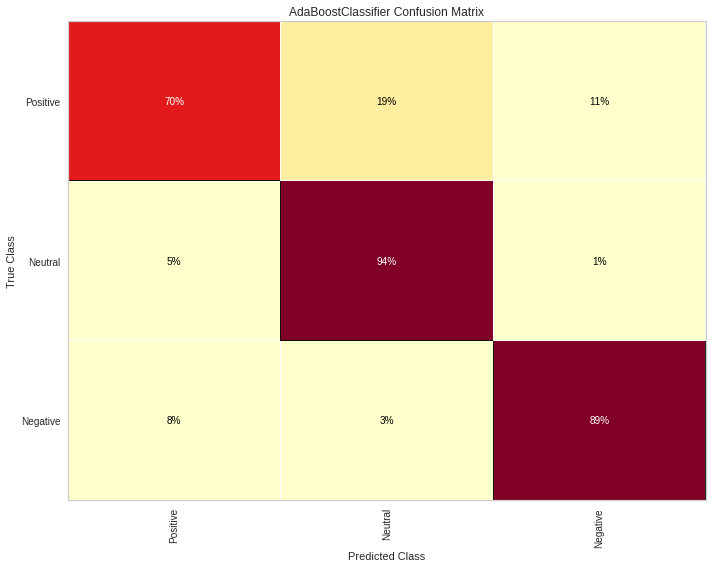

 78%|███████▊  | 7/9 [00:40<00:04,  2.47s/it]

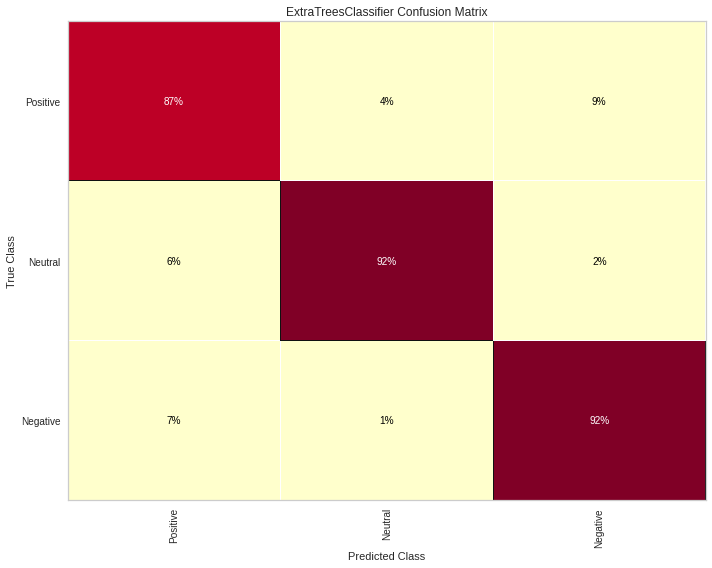

 89%|████████▉ | 8/9 [00:41<00:01,  1.99s/it]

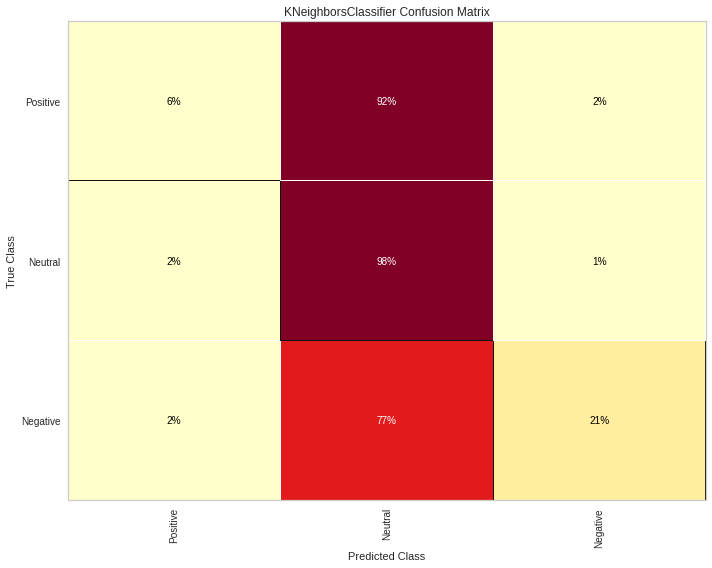

100%|██████████| 9/9 [00:52<00:00,  5.86s/it]


In [70]:
for model in tqdm(model_list_):
  plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val)

**Precision-Recall Curve**

In [72]:
def precision_recall_curve_plot(model, X_train, y_train, X_val, y_val):
  visualizer = PrecisionRecallCurve(model, per_class = True, fill_area = False, iso_f1_curves = True, fig = plt.figure(figsize=(8,8)))
  visualizer.fit(X_train, y_train)
  visualizer.score(X_val, y_val)
  visualizer.show()
  return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

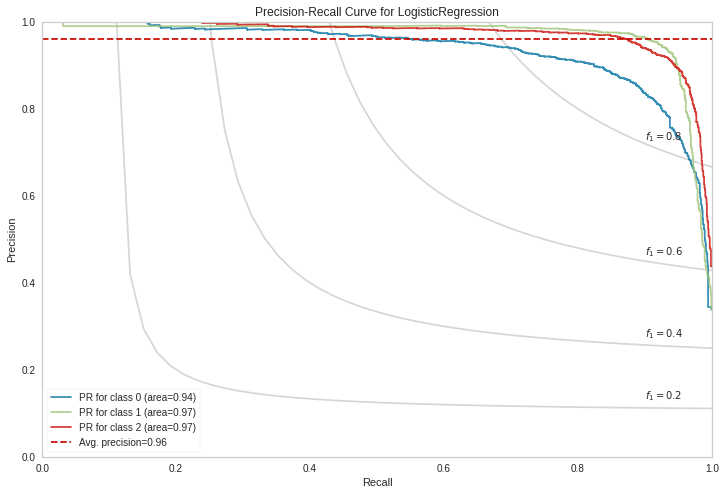

 11%|█         | 1/9 [00:02<00:21,  2.67s/it]

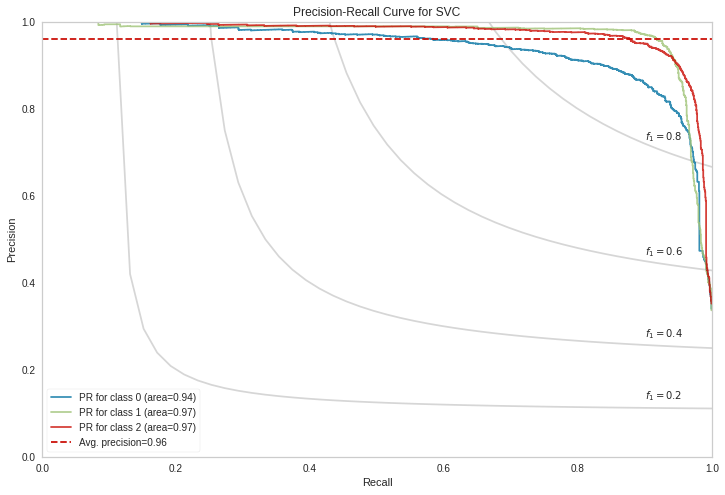

 22%|██▏       | 2/9 [16:22<1:07:22, 577.51s/it]

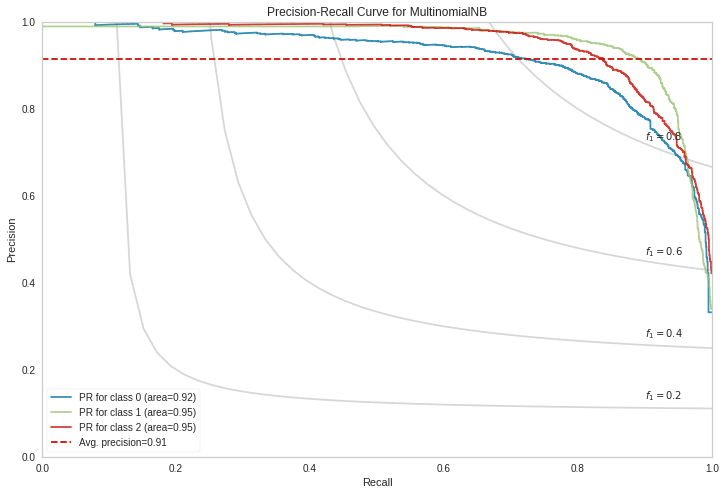

 33%|███▎      | 3/9 [16:23<31:24, 314.04s/it]  

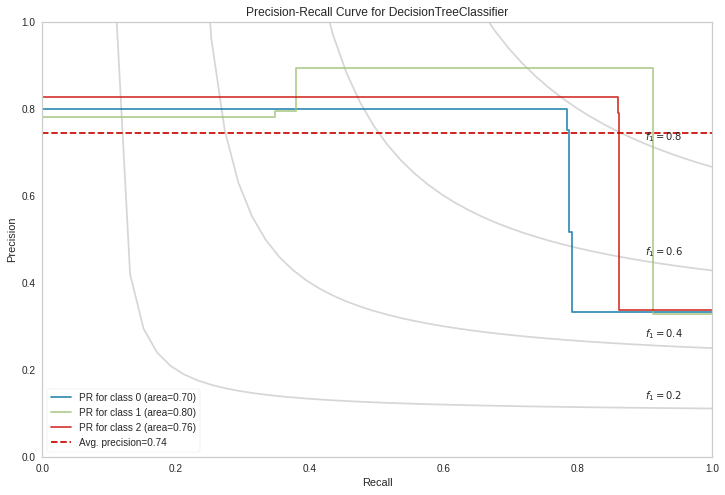

 44%|████▍     | 4/9 [17:04<17:11, 206.23s/it]

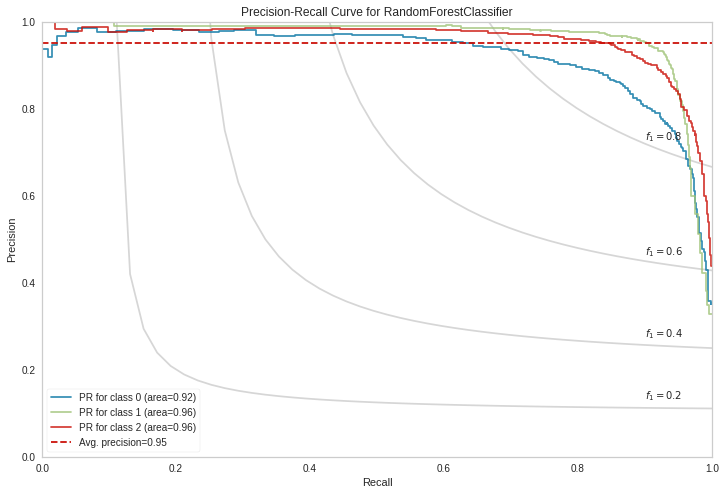

 56%|█████▌    | 5/9 [19:22<12:07, 181.96s/it]

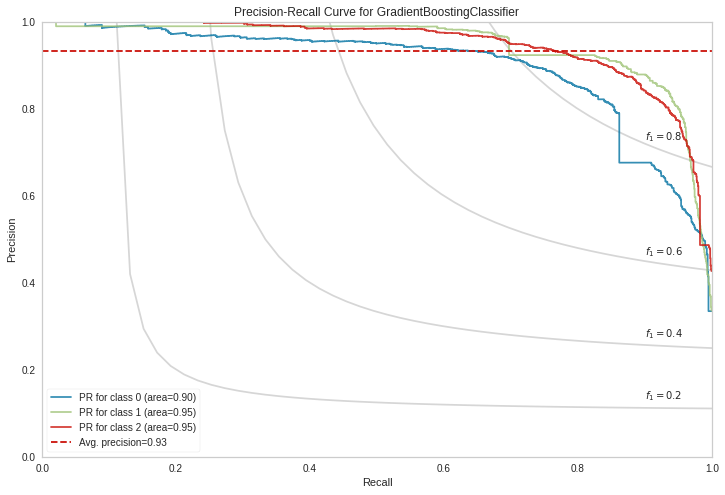

 67%|██████▋   | 6/9 [20:51<07:31, 150.33s/it]

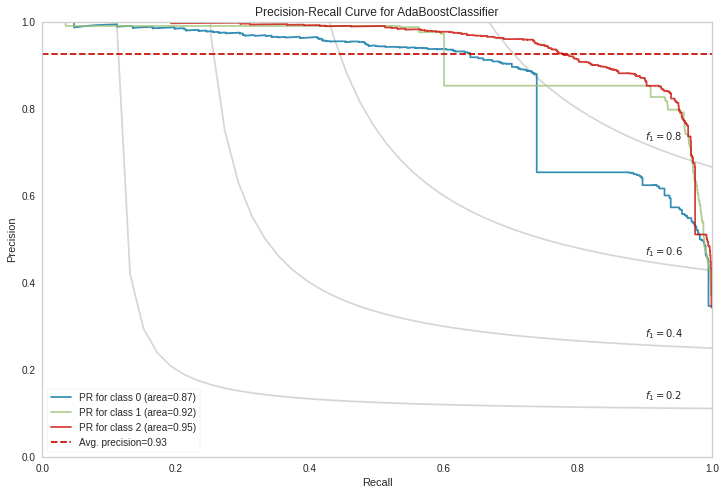

 78%|███████▊  | 7/9 [21:25<03:44, 112.09s/it]

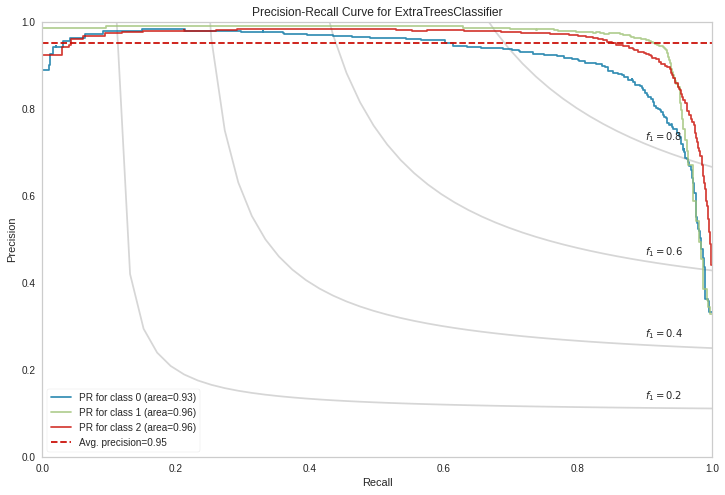

 89%|████████▉ | 8/9 [24:29<02:15, 135.07s/it]

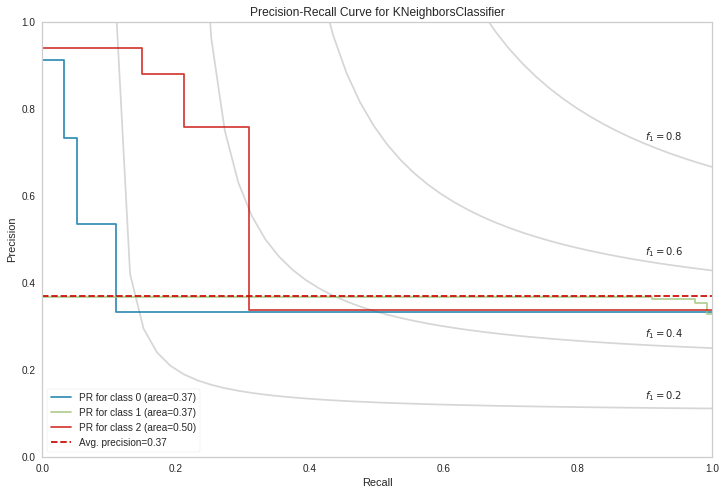

100%|██████████| 9/9 [25:02<00:00, 166.94s/it]


In [61]:
for model in tqdm(model_list_):
  precision_recall_curve_plot(model, X_train, y_train, X_val, y_val)

**Hyperparameter Tuning - RandomizedSearchCV**

In the hyperparameter tuning, instead of picking all models, we decide to perform the tuning for the top three models through a randomized search with cross-validation. The top three models are picked based on overall performance of the evaluation metrics. The primary aim was to improve a particular
evaluation metric for each of these model by choosing the scoring methods as follows:

1. KneighborsClassifier: F1 score
2. AdaBoostClassifier
3. GradientBoostingClassifier

Multinomial - no hyperparameters to tune

**KneighborsClassifier**

In [14]:
%%time
from sklearn.model_selection import RandomizedSearchCV
#List hyperparameters that we want to tune.
leaf_size = list(range(1,2,3))
n_neighbors = list(range(1,2,3))
p = [1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch
clf = RandomizedSearchCV(knn, hyperparameters, scoring = "f1_macro")

#Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
leaf_size = best_model.best_estimator_.get_params()['leaf_size']
p = best_model.best_estimator_.get_params()['p']
n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']

print('Best leaf_size:', leaf_size)
print('Best p:', p)
print('Best n_neighbors:', n_neighbors)

Best leaf_size: 1
Best p: 2
Best n_neighbors: 1
CPU times: user 5min 7s, sys: 3.54 s, total: 5min 10s
Wall time: 3min 15s


In [15]:
model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
model.fit(X_train, y_train)
model_predict = model.predict(X_val)
print("accuracy:", accuracy_score(model_predict, y_val))
print("precision_macro:", precision_score(model_predict, y_val, average = 'macro'))
print("recall_macro:", recall_score(model_predict, y_val, average = 'macro'))
print("f1_score_macro:", f1_score(model_predict, y_val, average = 'macro'))
print("jaccard_macro:", jaccard_score(model_predict, y_val, average = 'macro'))
print("fbeta_macro:", fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
print("roc_auc_score_macro:", roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
print("log_loss:", log_loss(y_val, model.predict_proba(X_val)))

accuracy: 0.43192584963954683
precision_macro: 0.4346683261687104
recall_macro: 0.6140252577424157
f1_score_macro: 0.36158224807697675
jaccard_macro: 0.2319257919527947
fbeta_macro: 0.3781142950447259
roc_auc_score_macro: 0.5761213471028858
log_loss: 19.62058605502856


**AdaBoostClassifier**

In [20]:
%%timeit

#List hyperparameters that we want to tune.
learning_rate = [0.1, 0.5, 1]
n_estimators = [10, 50, 250, 1000]

#Convert to dictionary
hyperparameters = dict(learning_rate = learning_rate, n_estimators = n_estimators)

#Create new KNN object
adaboost = AdaBoostClassifier(random_state = RANDOM_SEED)

#Use GridSearch
clf = RandomizedSearchCV(adaboost, hyperparameters, scoring = "f1_macro")

#Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
learning_rate = best_model.best_estimator_.get_params()['learning_rate']
n_estimators = best_model.best_estimator_.get_params()['n_estimators']

print('Best learning_rate:', learning_rate)
print('Best n_estimators:', n_estimators)

Best learning_rate: 0.5
Best n_estimators: 1000
Best learning_rate: 0.5
Best n_estimators: 1000


KeyboardInterrupt: ignored

In [22]:
%%timeit
model = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 1000, random_state = RANDOM_SEED)
model.fit(X_train, y_train)
model_predict = model.predict(X_val)
print("accuracy:", accuracy_score(model_predict, y_val))
print("precision_macro:", precision_score(model_predict, y_val, average = 'macro'))
print("recall_macro:", recall_score(model_predict, y_val, average = 'macro'))
print("f1_score_macro:", f1_score(model_predict, y_val, average = 'macro'))
print("jaccard_macro:", jaccard_score(model_predict, y_val, average = 'macro'))
print("fbeta_macro:", fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
print("roc_auc_score_macro:", roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
print("log_loss:", log_loss(y_val, model.predict_proba(X_val)))

accuracy: 0.8914521112255407
precision_macro: 0.8916472715304877
recall_macro: 0.891652741612821
f1_score_macro: 0.89106196155858
jaccard_macro: 0.8048753075697941
fbeta_macro: 0.8912683029417723
roc_auc_score_macro: 0.8713063228296837
log_loss: 1.0864363738533802
accuracy: 0.8914521112255407
precision_macro: 0.8916472715304877
recall_macro: 0.891652741612821
f1_score_macro: 0.89106196155858
jaccard_macro: 0.8048753075697941
fbeta_macro: 0.8912683029417723
roc_auc_score_macro: 0.8713063228296837
log_loss: 1.0864363738533802


KeyboardInterrupt: ignored

**GradientBoostingClassifier**

In [ ]:
%%timeit

#List hyperparameters that we want to tune.
learning_rate = [0.1, 0.5, 1]
n_estimators = [10, 50, 250, 1000]
max_depth = [1,5,10]

#Convert to dictionary
hyperparameters = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)

#Create new KNN object
Gradient = GradientBoostingClassifier(random_state = RANDOM_SEED)

#Use GridSearch
clf = RandomizedSearchCV(Gradient, hyperparameters, scoring = "f1_macro")

#Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
learning_rate = best_model.best_estimator_.get_params()['learning_rate']
n_estimators = best_model.best_estimator_.get_params()['n_estimators']
max_depth = best_model.best_estimator_.get_params()['max_depth']

print('Best learning_rate:', learning_rate)
print('Best n_estimators:', n_estimators)
print('Best max_depth:', max_depth)

In [ ]:
%%timeit

model = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth, random_state = RANDOM_SEED)
model.fit(X_train, y_train)
model_predict = model.predict(X_val)
print("accuracy:", accuracy_score(model_predict, y_val))
print("precision_macro:", precision_score(model_predict, y_val, average = 'macro'))
print("recall_macro:", recall_score(model_predict, y_val, average = 'macro'))
print("f1_score_macro:", f1_score(model_predict, y_val, average = 'macro'))
print("jaccard_macro:", jaccard_score(model_predict, y_val, average = 'macro'))
print("fbeta_macro:", fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
print("roc_auc_score_macro:", roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
print("log_loss:", log_loss(y_val, model.predict_proba(X_val)))

**Supervised Learning on Word Embedding**

#** ---------------------- Nishant's code - begin ----------------------**

In [ ]:
%%time

#### Downloading the GloVe word embedding trained by Stanford University
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
%%time

## Nishant: The archive contains 50, 100, 200 and 300 dimensional vectors. I am randomly using the 100 dimensional vector. 
## You can test different dimensions
## The model gives the embedding vector for 400,000 words
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
%%time

### We will use this function to find the embedding vector for each word in each row i.e. each document and then take the average of the embedding vectors for a document
### The other option was to take the sum but then some documents are longer than others so I chose average 
def create_doc_vector(doc):
  matrix1 = [embeddings_index[word] for word in doc.split() if word in embeddings_index.keys()]
  if len(matrix1) == 0:
    final_vec = np.zeros((100))
  else:
    final_vec =  np.mean(matrix1, axis = 0)
  return final_vec

In [ ]:
%%time

### comment 1: I noticed some cleaned_comments were NaN and I am dropping those rows
### comment 2: IMPORTANT: I have applied the function on the entire dataset. You can choose to apply it seperately to Train-Val-Test

cleaned_df = cleaned_df[cleaned_df['cleaned_comments'].isnull() == 0]

X_text = cleaned_df['cleaned_comments']
X_vectors = X_text.apply(create_doc_vector) 
X_final = np.stack(X_vectors) ###converting the panda series to an array of arrays

In [ ]:
%%time

zero_feature_rows = []
for i in range(X_final.shape[0]):
  if np.any(X_final[i]) == 0:
    zero_feature_rows.append(i)
X_finally_final = np.delete(X_final, zero_feature_rows, 0)

In [ ]:
X_finally_final.shape

In [ ]:
y_final = list(data_cleaned['sentiment'])
for i in zero_feature_rows:
  del y_final[i]

print(len(y_final))

In [ ]:
word_embedding_full_df = pd.DataFrame({'vectors': X_finally_final,'sentiment': y_final})

#** ---------------------- Nishant's code - end ----------------------**

#** ---------------------- Michael's code - begin ----------------------**

**check distribution of labels - should be the same**

In [ ]:
word_embedding_full_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title = 'Sentiment Count (target)')

**Undersampling word vectors**

In [ ]:
# class count
class_count_positive, class_count_neutral, class_count_negative = word_embedding_full_df['sentiment'].value_counts()


# Separate sentiment into each df
class_positive = word_embedding_full_df[word_embedding_full_df['sentiment'] == "Positive"]
class_neutral = word_embedding_full_df[word_embedding_full_df['sentiment'] == "Neutral"]
class_negative = word_embedding_full_df[word_embedding_full_df['sentiment'] == "Negative"]

print('class_positive:', class_positive.shape)
print('class_neutral:', class_neutral.shape)
print('class_negative:', class_negative.shape)
print("Random Under Sampling leads to.........")
      
# As negative sentiment is the lowest case count, we will do random undersampling for both positive and neutral sentiments to get an equally distributed and balanced dataset
class_positive_under = class_positive.sample(class_count_negative, random_state = RANDOM_SEED)
class_neutral_under = class_neutral.sample(class_count_negative, random_state = RANDOM_SEED)

# Combine all dataframes
word_embedding_undersampling_df = pd.concat([class_positive_under, class_neutral_under, class_negative], axis = 0)
word_embedding_undersampling_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title ='Sentiment Count (target)')

**Train test split**

In [ ]:
train_df, val_df, test_df = get_train_val_test(word_embedding_undersampling_df, fractions, RANDOM_SEED)

# training set
X_train = list(train_df.cleaned_comments)
y_train = list(train_df.sentiment)

# validation set
X_val = list(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

**Proceeding with supervised learning - same default models**

In [ ]:
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_svm = svm.SVC(decision_function_shape = 'ovr', probability = True, random_state = RANDOM_SEED)
clf_svm_ = svm.SVC(decision_function_shape = 'ovr', random_state = RANDOM_SEED) # without probability = True
clf_nb = MultinomialNB()
clf_dt = tree.DecisionTreeClassifier(random_state = RANDOM_SEED)
clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
clf_gbc = GradientBoostingClassifier(random_state = RANDOM_SEED)
clf_boost = AdaBoostClassifier(random_state = RANDOM_SEED)
clf_xtratree = ExtraTreesClassifier(random_state = RANDOM_SEED)
clf_knn = KNeighborsClassifier(n_neighbors = k)

model_names = ["LogisticRegression (Base)", "SupportVectorMachine", "MultinomialNB", "DecisionTreeClassifier", 
               "RandomForestClassifier", "GradientBoostingClassifier", "AdaBoostClassifier", "ExtraTreesClassifier", "KNeighborsClassifier"]

model_list = [clf_log, clf_svm, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]
model_list_ = [clf_log, clf_svm_, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]

In [ ]:
%%timeit

accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in tqdm(model_list):
  model.fit(X_train, y_train)
  model_predict = model.predict(X_val)
  accuracy.append(accuracy_score(model_predict, y_val))
  precision.append(precision_score(model_predict, y_val, average = 'macro'))
  recall.append(recall_score(model_predict, y_val, average = 'macro'))
  f1score.append(f1_score(model_predict, y_val, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_val, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_val, model.predict_proba(X_val)))

In [ ]:
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])